In [1]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import keras

from keras.utils import np_utils
from keras.optimizers import Adam

import os
import numpy as np
import itertools

import cv2
import os
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


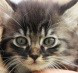

In [2]:
image.load_img("cat.jpg")

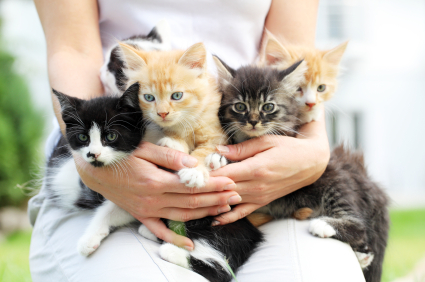

In [3]:
image.load_img("cats.jpg")

In [4]:
def _canny(img, size = 3):
    k = img.astype(np.uint8)
    k = cv2.blur(k, (size, size))
    k = cv2.Canny(k, 10, 200)
    k = cv2.blur(k, (size, size))
    return k

def find_template(img, pattern, use_canny = True, canny_blur_size = 5, method = cv2.TM_SQDIFF, 
                  estimate_scale=False,
                  debugDrawMatch=False, 
                  debugDrawPoint=False):
    if isinstance(img, str):
        img_array = image.img_to_array(image.load_img(img))
    else:
        img_array = img
    
    if isinstance(pattern, str):
        pat_array = image.img_to_array(image.load_img(pattern))
    else:
        pat_array = img
    
    if use_canny:
        img_grayscale = _canny(img_array, canny_blur_size)
        pat_grayscale = _canny(pat_array, canny_blur_size)
    else:
        img_grayscale = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)
        pat_grayscale = cv2.cvtColor(pat_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    if estimate_scale:
        pad_w = img_grayscale.shape[0] - pat_grayscale.shape[0]
        pad_h = img_grayscale.shape[1] - pat_grayscale.shape[1]
        pat_grayscale = np.pad(pat_grayscale, 
                               ((int(pad_w/2), pad_w - int(pad_w/2)), (int(pad_h/2), pad_h - int(pad_h/2))), mode="constant")
        match, scale, angle, point = similarity(pat_grayscale, img_grayscale)
        print(scale, angle, point)
        point[0] += int(pad_w/2)
        point[1] += int(pad_h/2)
        if point[0] < 0:
            point[0] += img_grayscale.shape[0]
        if point[1] < 0:
            point[1] += img_grayscale.shape[1]
    else:
        match = cv2.matchTemplate(pat_grayscale, img_grayscale, method)
        if method in (cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED):
            point = np.argmin(match)
        else:
            point = np.argmax(match)
        point = np.unravel_index(point, match.shape)
        scale = 1.0
    if debugDrawMatch:
        plt.axis("off")
        plt.imshow(match)
        plt.colorbar()
        plt.show()
    debug_point = cv2.rectangle(img_array, 
                            (int(point[1] ), int(point[0])), 
                            (int(point[1] + pat_array.shape[1] * scale), int(point[0] + pat_array.shape[0] * scale)), 
                            (255, 0, 0), 3).astype(np.uint8)
    if debugDrawPoint:
        plt.axis("off")
        plt.imshow(debug_point)
        plt.show()
    return point, match, debug_point

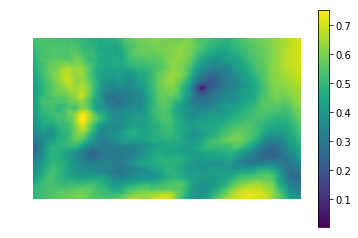

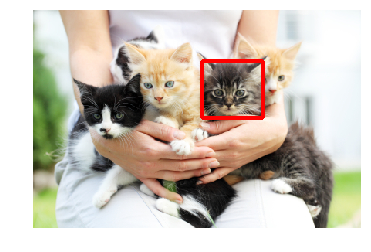

In [5]:
_ = find_template("cats.jpg", "cat.jpg", False, method = cv2.TM_SQDIFF_NORMED, estimate_scale=False,
              debugDrawMatch = True, 
              debugDrawPoint = True)

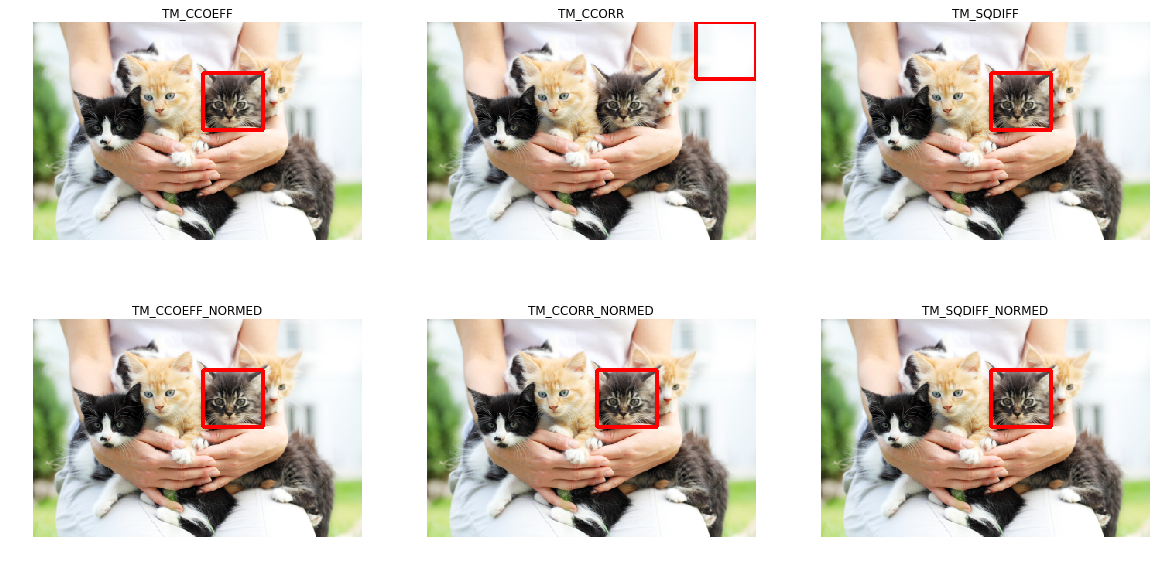

In [6]:
plt.figure(figsize=(20,10))
for i, (m, m_name) in enumerate([(cv2.TM_CCOEFF, "TM_CCOEFF"), 
                                 (cv2.TM_CCORR, "TM_CCORR"),
                                 (cv2.TM_SQDIFF, "TM_SQDIFF"),
                                (cv2.TM_CCOEFF_NORMED, "TM_CCOEFF_NORMED"),
                                 (cv2.TM_CCORR_NORMED, "TM_CCORR_NORMED"), 
                                 (cv2.TM_SQDIFF_NORMED, "TM_SQDIFF_NORMED")]):
    plt.subplot(2, 3, i+1)
    plt.axis("off")
    plt.title(m_name)
    plt.imshow(find_template("cats.jpg", "cat.jpg", False, method = m)[2])
plt.show()

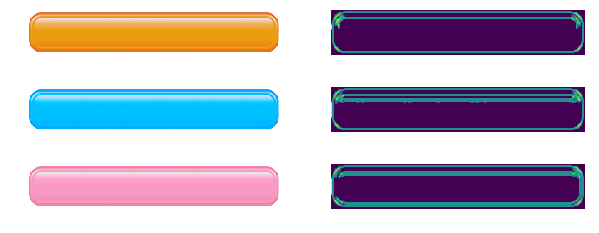

In [7]:
plt.figure(figsize=(10, 4))
for i, (img_name) in enumerate(["paper_data/button1.png", "paper_data/button1_blue.png", "paper_data/button1_pink.png"]):
    k = image.img_to_array(image.load_img(img_name))
    
    plt.subplot(3, 2, i * 2 + 1)
    plt.axis("off")
    plt.imshow(k.astype(np.uint8))
    
    plt.subplot(3, 2, i * 2 + 2)
    plt.axis("off")
    plt.imshow(_canny(k))

plt.show()


In [8]:
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii
import math

import numpy
# -*- coding: utf-8 -*-
# imreg.py

# Copyright (c) 2011-2018, Christoph Gohlke
# Copyright (c) 2011-2018, The Regents of the University of California
# Produced at the Laboratory for Fluorescence Dynamics
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# * Redistributions of source code must retain the above copyright
#   notice, this list of conditions and the following disclaimer.
# * Redistributions in binary form must reproduce the above copyright
#   notice, this list of conditions and the following disclaimer in the
#   documentation and/or other materials provided with the distribution.
# * Neither the name of the copyright holders nor the names of any
#   contributors may be used to endorse or promote products derived
#   from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

"""FFT based image registration.

Implements an FFT-based technique for translation, rotation and scale-invariant
image registration [1].

:Author:
  `Christoph Gohlke <https://www.lfd.uci.edu/~gohlke/>`_

:Organization:
  Laboratory for Fluorescence Dynamics, University of California, Irvine

:Version: 2018.02.07

Requirements
------------
* `CPython 2.7 or 3.6 <https://www.python.org>`_
* `Numpy 1.13 <http://www.numpy.org>`_
* `Scipy 1.0 <http://www.scipy.org>`_
* `Matplotlib 2.1 <http://www.matplotlib.org>`_  (optional for plotting)

Notes
-----
The API and algorithms are not stable yet and are expected to change between
revisions.

An improved version of this module is developed at
<https://github.com/matejak/imreg_dft>.

References
----------
(1) An FFT-based technique for translation, rotation and scale-invariant
    image registration. BS Reddy, BN Chatterji.
    IEEE Transactions on Image Processing, 5, 1266-1271, 1996
(2) An IDL/ENVI implementation of the FFT-based algorithm for automatic
    image registration. H Xiea, N Hicksa, GR Kellera, H Huangb, V Kreinovich.
    Computers & Geosciences, 29, 1045-1055, 2003.
(3) Image Registration Using Adaptive Polar Transform. R Matungka, YF Zheng,
    RL Ewing. IEEE Transactions on Image Processing, 18(10), 2009.

Examples
--------
>>> im0 = imread('t400')
>>> im1 = imread('Tr19s1.3')
>>> im2, scale, angle, (t0, t1) = similarity(im0, im1)
>>> imshow(im0, im1, im2)

>>> im0 = imread('t350380ori')
>>> im1 = imread('t350380shf')
>>> t0, t1 = translation(im0, im1)

"""

from __future__ import division, print_function

import math

import numpy
from numpy.fft import fft2, ifft2, fftshift

import scipy.ndimage.interpolation as ndii

__version__ = '2018.02.07'
__docformat__ = 'restructuredtext en'
__all__ = 'translation', 'similarity'


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), shape)
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return [t0, t1]



def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    All image areas must have same scale, rotation, and shift.
    Scale change must be less than 1.8.
    No subpixel precision.

    """
    if im0.shape != im1.shape:
        raise ValueError('Images must have same shapes.')
    elif len(im0.shape) != 2:
        raise ValueError('Images must be 2 dimensional.')

    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))

    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
    del h

    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)

    f0 = fft2(f0)
    f1 = fft2(f1)
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
    angle = 180.0 * i0 / ir.shape[0]
    scale = log_base ** i1

    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError('Images are not compatible. Scale change > 1.8')

    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0
    angle = 0.0
    
    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)

    if im2.shape < im0.shape:
        t = numpy.zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]

    f0 = fft2(im0)
    f1 = fft2(im2)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)

    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]

    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
    if angle > 0.0:
        d = int((int(im1.shape[1] / scale) * math.sin(math.radians(angle))))
        t0, t1 = t1, d+t0
    elif angle < 0.0:
        d = int((int(im1.shape[0] / scale) * math.sin(math.radians(angle))))
        t0, t1 = d+t1, d+t0
    scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]



def similarity_matrix(scale, angle, vector):
    """Return homogeneous transformation matrix from similarity parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector (of size 2).

    The order of transformations is: scale, rotate, translate.

    """
    S = numpy.diag([scale, scale, 1.0])
    R = numpy.identity(3)
    angle = math.radians(angle)
    R[0, 0] = math.cos(angle)
    R[1, 1] = math.cos(angle)
    R[0, 1] = -math.sin(angle)
    R[1, 0] = math.sin(angle)
    T = numpy.identity(3)
    T[:2, 2] = vector
    return numpy.dot(T, numpy.dot(R, S))


def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = numpy.empty((angles, radii), dtype='float64')
    theta.T[:] = numpy.linspace(0, numpy.pi, angles, endpoint=False) * -1.0
    # d = radii
    d = numpy.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (math.log10(d) / (radii))
    radius = numpy.empty_like(theta)
    radius[:] = numpy.power(log_base,
                            numpy.arange(radii, dtype='float64')) - 1.0
    x = radius * numpy.sin(theta) + center[0]
    y = radius * numpy.cos(theta) + center[1]
    output = numpy.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    x = numpy.outer(
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[0])),
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)


def imread(fname, norm=True):
    """Return image data from img&hdr uint8 files."""
    with open(fname+'.hdr', 'r') as fh:
        hdr = fh.readlines()
    img = numpy.fromfile(fname+'.img', numpy.uint8, -1)
    img.shape = int(hdr[4].split()[-1]), int(hdr[3].split()[-1])
    if norm:
        img = img.astype('float64')
        img /= 255.0
    return img


def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
    """Plot images using matplotlib."""
    from matplotlib import pyplot
    if cmap is None:
        cmap = 'coolwarm'
    if im3 is None:
        im3 = abs(im2 - im0)
    pyplot.subplot(221)
    pyplot.imshow(im0, cmap, **kwargs)
    pyplot.subplot(222)
    pyplot.imshow(im1, cmap, **kwargs)
    pyplot.subplot(223)
    pyplot.imshow(im3, cmap, **kwargs)
    pyplot.subplot(224)
    pyplot.imshow(im2, cmap, **kwargs)
    pyplot.show()

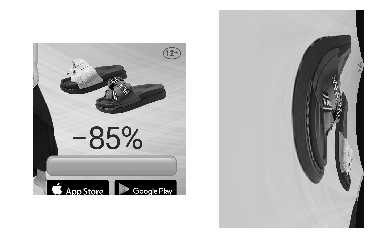

In [9]:
img_array = image.img_to_array(image.load_img("sample_creative1.jpg"))[:600, -600:]

img_grayscale = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_grayscale, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(logpolar(img_grayscale, radii=400)[0], cmap='gray')

/home/grozin/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.9892739273927392 0.0 [177, 322]
0.9892739273927392 0.0 [275, 199]
1.0 0.0 [163, -138]


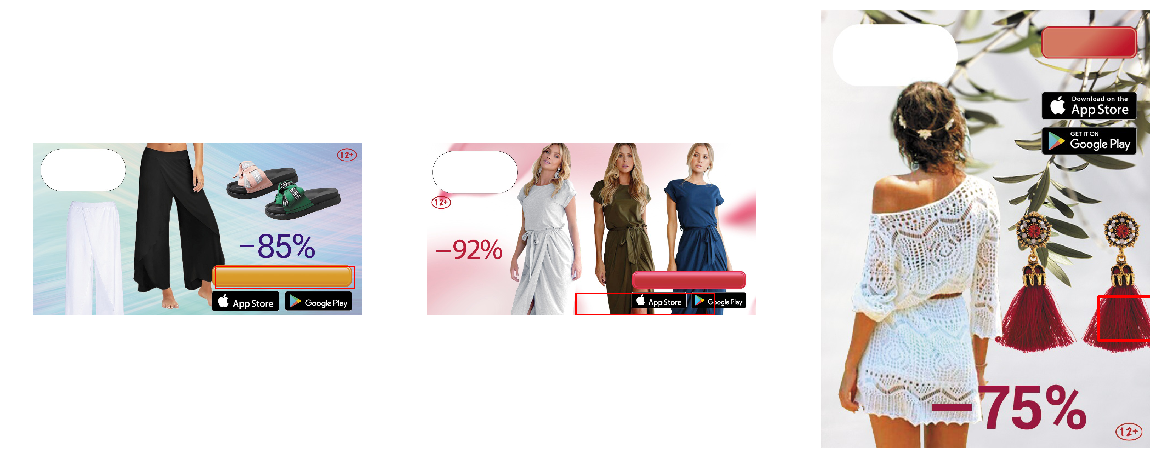

In [10]:
plt.figure(figsize=(20,10))
for i, (img_name) in enumerate(["sample_creative1.jpg", "sample_creative2.jpg", "sample_creative3.jpg"]):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    match = find_template(img_name, "button.jpg", True, 3, method = cv2.TM_SQDIFF, estimate_scale=True, debugDrawMatch=False)[2]
    plt.imshow(match)
plt.show()